###Phi-3-vision
The Phi-3-Vision-128K-Instruct is a cutting-edge, lightweight open multimodal model from the Phi-3 model family. It is built on datasets that include synthetic data and filtered public websites, focusing on high-quality, reasoning-intensive text and vision data. This multimodal version supports a context length of up to 128K tokens. The model has been extensively enhanced through supervised fine-tuning and direct preference optimization, ensuring precise instruction adherence and robust safety features.

In [1]:
import torch
print(torch.cuda.is_available())

True


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [1]:
! pip install flash_attn==2.5.8 transformers==4.40.2 accelerate torchvision torch Requests Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 11.2 MB/s eta 0:00:00
  Using cached ninja-1.11.1.1-py2.py3-none-manylinux1_x86_64.manylinux_2_5_x86_64.whl.metadata (5.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 61.6 MB/s eta 0:00:00
Using cached ninja-1.11.1.1-py2.py3-none-manylinux1_x86_64.manylinux_2_5_x86_64.whl (307 kB)
^C


In [4]:
from PIL import Image
import requests
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor
import accelerate

In [5]:
def display_image(url):
  image = Image.open(requests.get(url, stream=True).raw)
  display(image)
  return image


In [6]:
def load_model():
  model_id = "microsoft/Phi-3-vision-128k-instruct"
  model = AutoModelForCausalLM.from_pretrained(model_id, device_map='cuda', trust_remote_code=True, torch_dtype=torch.float16)
  processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True, torch_dtype=torch.float16)
  return model, processor

In [7]:
model, processor = load_model()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/image_processing_auto.py:513: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [8]:
def generate_emotions(task_prompt, image, model, processor):
  prompt_with_image = f"<|image_1|>\n{task_prompt}"
  message = [{"role": "user", "content": prompt_with_image}]
  prompt = processor.tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=True)
  inputs = processor(prompt, [image], return_tensors="pt").to("cuda", torch.float16)
  generation_args = {"max_new_tokens": 500, "do_sample": False}
  generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)
  output = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
  return output

In [ ]:

image

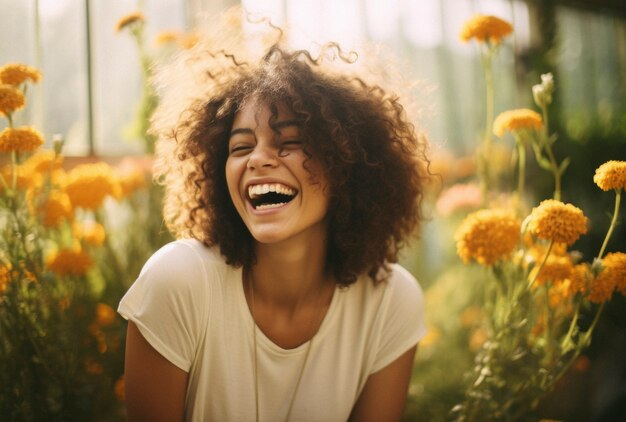

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
/root/.cache/huggingface/modules/transformers_modules/microsoft/Phi-3-vision-128k-instruct/c45209e90a4c4f7d16b2e9d48503c7f3e83623ed/image_embedding_phi3_v.py:197: UserWarning: Phi-3-V modifies `input_ids` in-place and the tokens indicating images will be removed after model forward. If your workflow requires multiple forward passes on the same `input_ids`, please make a copy of `input_ids` before passing it to the model.
  warnings.warn(


RuntimeError: FlashAttention only supports Ampere GPUs or newer.

In [9]:
url = 'https://img.freepik.com/free-photo/photorealistic-happiness-scene-with-happy-woman_23-2151423469.jpg?size=626&ext=jpg&ga=GA1.1.2008272138.1720569600&semt=ais_user'
image = display_image(url)
task_prompt = "Provide the emotion portrayed in the image"
answer = generate_emotions(task_prompt, image, model, processor)
print(answer)

###BLIP-2

BLIP-2 (Bootstrapping Language-Image Pre-training with frozen unimodal models)narrows the gap between vision and language models by incorporating a lightweight Querying Transformer (Q-Former) between a pre-trained, frozen image encoder and a frozen large language model. In BLIP-2, the Q-Former is the only component that is trainable, while both the image encoder and language model remain unchanged.